# import modules

In [1]:
import sys
sys.path.append('/home/xiaoxinyu/TorchFiber')

from src.NewSimulation.config import *
tx_data = simpleWDMTx(False, jax.random.PRNGKey(0), batch=1, M=16, Nbits=6000, sps=16, Nch=1, Nmodes=1, Rs=36e9, freqspace=50e9, Pch_dBm=0)
Pch = 10**(tx_data['config']['Pch_dBm']/10)*1e-3
tx_data['signal'] = tx_data['signal'] / jnp.sqrt(Pch)         # power normalization
print('(batch, Nfft, Nmodes), (batch, Nsymb, Nch, Nmodes)')
print(tx_data['signal'].shape, tx_data['SymbTx'].shape)


print(f'\nEach fiber span length Ls = {Ls} km.')
print(f'Dispersion length Ld = {Ld} km.')
print(f'Nonlinear length Lnl = {Lnl} km.')
print(f'nonlinear coeff gamma = {gamma} /W/km .')

/home/xiaoxinyu/.conda/envs/fiber/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


gamma = 0.1


2024-01-11 11:04:09.704074: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Sample rate fa: 5.76e+11, Cut off frequency fc: 2.5e+10, fa > 2fc: True
 simpleWDMTx complete, time cost(s):2.2672529220581055
(batch, Nfft, Nmodes), (batch, Nsymb, Nch, Nmodes)
(1, 24000, 1) (1, 1500, 1, 1)

Each fiber span length Ls = 80 km.
Dispersion length Ld = 40 km.
Nonlinear length Lnl = 400 km.
nonlinear coeff gamma = 0.1 /W/km .


# approximated X

# solve NLSE

In [33]:
# initial condition
u0 = tx_data['signal'][0,:,0]

# parameters
spans = 8
z_max = spans*Ls/Ld
dt = 1/tx_data['config']['sps']
print(f'z_max = {z_max} Ld')

# solve with full sps = 16
uc = Dispersion(u0, dt, z_max)                                          # dispersion solution
us = SSFM(u0, dt, dz=1, L=z_max, gamma=gamma, order=1, path=False)      # large step solution
ur = SSFM(u0, dt, dz=1/2**8, L=z_max, gamma=gamma, order=2, path=False) # real solution

z_max = 16.0 Ld
dispersion only: 0.6813180398706223
SSFM: 0.073338486


In [45]:
# solve with downsampled sps = 2 and reconstruct to sps=16.
rate = 16
u0_downsamp = u0[::rate]    # sps=16 --> sps=2
uc_downsamp = SSFM(u0_downsamp, dt*rate, dz=z_max,  L=z_max, gamma=0, order=1, path=False)       # dispersion solution
us_downsamp = SSFM(u0_downsamp, dt*rate, dz=1,    L=z_max, gamma=gamma, order=1,path=False)     # NLSE solution
ur_downsamp = SSFM(u0_downsamp, dt*rate, dz=1/2**6, L=z_max, gamma=gamma, order=2,path=False)  # real solution

uc1 = reconstruct(uc_downsamp, rate)   # sps=2 --> sps=16  dispersion solution
us1 = reconstruct(us_downsamp, rate)   # sps=2 --> sps=16  large step solution
ur1 = reconstruct(ur_downsamp, rate)   # sps=2 --> sps=16  real solution (small step)

def MSE(u, ur):
    return np.mean(np.abs(ur - u)**2)

print('dispersion only:', MSE(uc, ur))
print('SSFM large dz:', MSE(us1, ur))
print('SSFM small dz:', MSE(ur1, ur))

dispersion only: 0.6813180398706223
SSFM large dz: 0.06737972
SSFM small dz: 0.058934163


In [46]:
import pickle

def NonlinearCouple(a, X, S):
    a_delta = np.zeros_like(a)
    for (m,n,k) in S:
        a_delta += X[m, n, k]*np.roll(a, m)*np.roll(a, n)*np.roll(a, k).conj()
    return -(1j)*gamma*a_delta

def MSE(u, ur):
    return np.mean(np.abs(ur - u)**2)

In [6]:
import pickle
X,z = pickle.load(open('../data/Xcoeff_161_dz1_zmax16.pkl', 'rb'))
Xint = np.sum(X*f(z)[:, None, None, None]*z[1], axis=0)

l = X.shape[-1]//2
S1 = [(m,n,k) for m in range(-l,l+1) for n in range(-l,l+1) for k in range(-l,l+1)]
S2 = [(m,n,k) for m in range(-l,l+1) for n in range(-l,l+1) for k in range(-l,l+1) if k == m+n]
S3 = [(m,n,k) for m in range(-l,l+1) for n in range(-l,l+1) for k in range(-l,l+1) if k == m+n and m*n==0]
S4  = [(m,n,k) for m in range(-l,l+1) for n in range(-l,l+1) for k in range(-l,l+1) if np.abs(Xint[m,n,k]) > 1e-2]
S5  = [(m,n,k) for (m,n,k) in S3 if np.abs(Xint[m,n,k]) > 2e-2]
S6  = [(m,n,k) for (m,n,k) in S2 if np.abs(Xint[m,n,k]) > 2e-2]

In [51]:
S5  = [(m,n,k) for (m,n,k) in S3 if np.abs(Xint[m,n,k]) > 5e-3]
S6  = [(m,n,k) for (m,n,k) in S2 if np.abs(Xint[m,n,k]) > 5e-3]

In [52]:
print(f'S1 length: {len(S1)}')
print(f'S2 length: {len(S2)}')
print(f'S3 length: {len(S3)}')
print(f'S4 length: {len(S4)}')
print(f'S5 length: {len(S5)}')
print(f'S6 length: {len(S6)}')

S1 length: 4173281
S2 length: 19441
S3 length: 321
S4 length: 1321
S5 length: 321
S6 length: 4119


## Euler

In [53]:
er_list1 = []

for step_size in [16, 8, 4, 2, 1]:
    u1 = u0_downsamp
    for i in range(0, len(z)-1, step_size):
        phi = NonlinearCouple(u1, sum([X[j]*f(z[j]) for j in range(i, i+step_size)]), S6)*z[1]            
        u1 = u1 + phi

    u1 = Dispersion(u1, dt*rate, z_max)
    u1_rec = reconstruct(u1, rate)

    er_list1.append(MSE(u1_rec, ur))
    print('step size:', step_size)
    print('dispersion only:', MSE(uc, ur))
    print('RP1:', MSE(u1_rec, ur))
    print('SSFM:', MSE(us1, ur))

step size: 16
dispersion only: 0.6813180398706223
RP1: 0.18431747
SSFM: 0.06737972
step size: 8
dispersion only: 0.6813180398706223
RP1: 0.12110625
SSFM: 0.06737972
step size: 4
dispersion only: 0.6813180398706223
RP1: 0.102668196
SSFM: 0.06737972
step size: 2
dispersion only: 0.6813180398706223
RP1: 0.10064613
SSFM: 0.06737972
step size: 1
dispersion only: 0.6813180398706223
RP1: 0.101006
SSFM: 0.06737972


In [54]:
er_list2 = []

for step_size in [16, 8, 4, 2, 1]:
    u1 = u0_downsamp
    for i in range(0, len(z)-1, step_size):
        phi = NonlinearCouple(u1, sum([X[j]*f(z[j]) for j in range(i, i+step_size)]), S6)*z[1]            
        u1 = u1 * np.exp(phi.imag*(1j) / u1) + phi.real

    u1 = Dispersion(u1, dt*rate, z_max)
    u1_rec = reconstruct(u1, rate)

    er_list2.append(MSE(u1_rec, ur))
    print('step size:', step_size)
    print('dispersion only:', MSE(uc, ur))
    print('RP1:', MSE(u1_rec, ur))
    print('SSFM:', MSE(us1, ur))

step size: 16
dispersion only: 0.6813180398706223
RP1: 0.17948495
SSFM: 0.06737972
step size: 8
dispersion only: 0.6813180398706223
RP1: 0.12036448
SSFM: 0.06737972
step size: 4
dispersion only: 0.6813180398706223
RP1: 0.10406065
SSFM: 0.06737972
step size: 2
dispersion only: 0.6813180398706223
RP1: 0.1019584
SSFM: 0.06737972
step size: 1
dispersion only: 0.6813180398706223
RP1: 0.10210498
SSFM: 0.06737972


In [55]:
er_list3 = []

for step_size in [16, 8, 4, 2, 1]:
    u1 = u0_downsamp
    for i in range(0, len(z)-1, step_size):
        phi = NonlinearCouple(u1, sum([X[j]*f(z[j]) for j in range(i, i+step_size)]), S6)*z[1]            
        u1 = u1 * np.exp(phi / u1)

    u1 = Dispersion(u1, dt*rate, z_max)
    u1_rec = reconstruct(u1, rate)

    er_list3.append(MSE(u1_rec, ur))
    print('step size:', step_size)
    print('dispersion only:', MSE(uc, ur))
    print('RP1:', MSE(u1_rec, ur))
    print('SSFM:', MSE(us1, ur))

step size: 16
dispersion only: 0.6813180398706223
RP1: 0.104782514
SSFM: 0.06737972
step size: 8
dispersion only: 0.6813180398706223
RP1: 0.104394265
SSFM: 0.06737972
step size: 4
dispersion only: 0.6813180398706223
RP1: 0.10419556
SSFM: 0.06737972
step size: 2
dispersion only: 0.6813180398706223
RP1: 0.10413214
SSFM: 0.06737972
step size: 1
dispersion only: 0.6813180398706223
RP1: 0.104127906
SSFM: 0.06737972


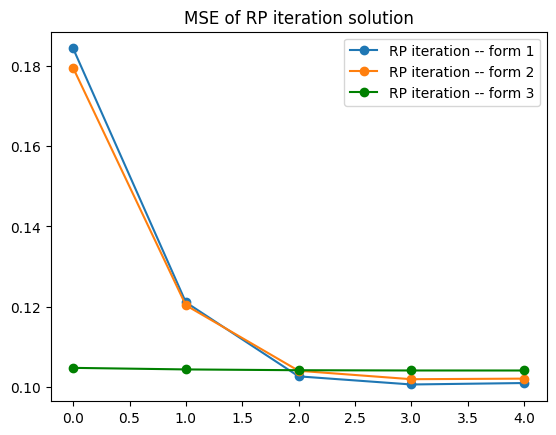

In [56]:
plt.plot(er_list1, marker='o', linestyle='-', label='RP iteration -- form 1')
plt.plot(er_list2, marker='o', linestyle='-', label='RP iteration -- form 2')
plt.plot(er_list3, marker='o', linestyle='-', label='RP iteration -- form 3', color='g')
plt.title('MSE of RP iteration solution')
plt.legend()

In [14]:
u1 = u0_downsamp
step_size = 8
for i in range(0, len(z)-1, step_size):
    phi = NonlinearCouple(u1, sum([X[j]*f(z[j]) for j in range(i, i+step_size)]), S4)*z[1]            
    u1 = u1*np.exp(phi / u1)

u1 = Dispersion(u1, dt*rate, z_max)
u1_rec = reconstruct(u1, rate)

print('dispersion only:', MSE(uc, ur))
print('RP1:', MSE(u1_rec, ur))
print('SSFM:', MSE(us1, ur))

dispersion only: 0.6813180398706223
RP1: 0.10113662
SSFM: 0.06737972
